# Imports

FastAI makes prototyping deep learning models simple.     
Hoever the library is not updated to pip frequnetly. 

In [1]:
import sys
sys.path.append("/home/ubuntu/fastai/")

In [2]:
import fastai
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from glob import glob
import pandas as pd
import helper
from tqdm import tqdm
import hashlib
from urllib import request


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
# sorted by size of data
# DATASET_NAME = "dog_breed"
#DATASET_NAME = "leaf"
DATASET_NAME = "food"
#DATASET_NAME = "bird"
#DATASET_NAME = "fungus"

PATH = f"data/{DATASET_NAME}"

In [5]:
!ls {PATH}

labels.csv  tmp  train	valid


# Train data

transformations to apply on the image

In [6]:
transforms_side_on

In [7]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on,
                           max_zoom=1.1)
    data = ImageClassifierData.from_paths(path=PATH
            , num_workers=8
            , tfms=tfms, bs=bs)
    #return data.resize(sz, 'tmp')
    return data if sz>300 else data.resize(340, 'tmp')

In [8]:
sz = 224 # size of image
arch = resnet34 #model architecture..
bs=128 # batch size; number of images to process at one time

In [9]:
! rm -rf {PATH}/tmp/

** Train with precompute weights **       
To speed up training, you can disable data augmentation.      
When data augmentation is off, you can cache the precomputed weights

In [10]:
data = get_data(sz, bs)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(lrs=1e-2, n_cycle=3)

                                                    
100%|██████████| 16/16 [00:10<00:00,  1.57it/s]


epoch      trn_loss   val_loss   accuracy                 
    0      1.065785   0.603735   0.798     
    1      0.780797   0.511624   0.836                     
    2      0.67121    0.455347   0.853                     



[array([0.45535]), 0.8530000009536743]

** Train with data augmentation **

In [11]:
learn.precompute = False
learn.fit(lrs=1e-2, n_cycle=5, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.644617   0.449032   0.857     
    1      0.63145    0.439297   0.8575                    
    2      0.619033   0.432397   0.854                     
    3      0.601428   0.417755   0.8605                    
    4      0.592837   0.41356    0.8645                    



[array([0.41356]), 0.8645]

** Train more with layer unfreezing **

In [ ]:
#learn.unfreeze()

In [ ]:
#lr=1e-2
#lr=np.array([lr/18,lr/6,lr/2])

In [ ]:
#learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
!ls

** calculate accuracy with test time augmentation **

In [12]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),axis=0) # normalize accuracies to between 0 - 1
(metrics.log_loss(y,preds), accuracy_np(preds,y))

(0.4135916541836198, 0.868)

In [13]:
predicted_class = np.argmax(preds, axis=1)
confidence = np.max(preds, axis=1)

In [14]:
predictions_df = pd.DataFrame ({'actual': y, 'pred': predicted_class,'image':learn.data.val_ds.fnames,'conf':confidence})

In [15]:
predictions_df['actual_class'] = predictions_df['actual'].apply(lambda x : data.classes[x])
predictions_df['pred_class'] = predictions_df['pred'].apply(lambda x : data.classes[x])

In [16]:
predictions_df.head()


,actual,pred,image,conf,actual_class,pred_class
0,0,0,valid/bruschetta/190768.jpg,0.952787,bruschetta,bruschetta
1,0,0,valid/bruschetta/812769.jpg,0.986058,bruschetta,bruschetta
2,0,1,valid/bruschetta/1279501.jpg,0.631336,bruschetta,fried_calamari
3,0,0,valid/bruschetta/1689549.jpg,0.754061,bruschetta,bruschetta
4,0,0,valid/bruschetta/828467.jpg,0.623873,bruschetta,bruschetta


In [17]:
def predict_class(image_path:str):
    """
    Given an image path (local filesystem), return most top predictions
    """
    
    # retrieve the transformation functions used by the DNN architecture
    trn_tfms, val_tfms = tfms_from_model(arch, sz)
    # read image and apply transforms
    im = val_tfms(np.array(open_image(image_path)))

    # get probability for all n classes
    preds = learn.predict_array(im[None])
    # get idx of most likely class
    class_idx = np.argmax(preds)
    
    print(data.classes[class_idx],np.max(preds))
    
    return helper.get_top_n_predictions(np.exp(preds), data.classes)
    #return np.argmax(preds)

def predict_class_web(url,ext="jpg"):
    url_hash = hashlib.md5(url.encode('utf-8')).hexdigest()
    file_name = f'data/downloaded/{url_hash}.{ext}'
    f = open(file_name, 'wb')
    f.write(request.urlopen(url).read())
    f.close()
    
    return predict_class(file_name)

In [18]:
!mkdir -p data/downloaded

In [19]:
predict_class_web("https://vetstreet.brightspotcdn.com/dims4/default/3407f3b/2147483647/thumbnail/645x380/quality/90/?url=https%3A%2F%2Fvetstreet-brightspot.s3.amazonaws.com%2Ffb%2F31%2F032a6aae436a9821acda211044fb%2Fbulldog-ap-rn4myi-645.jpg")

waffles -0.83217406


[('waffles', 0.4351023),
 ('red_velvet_cake', 0.2871008),
 ('spring_rolls', 0.11571563),
 ('tacos', 0.07704235),
 ('hot_and_sour_soup', 0.035255868)]

In [20]:
len(preds.shape)

2

** Confusion Matrix**

In [21]:
labels = learn.data.classes
cm = confusion_matrix(predictions_df['actual'], predictions_df['pred'])

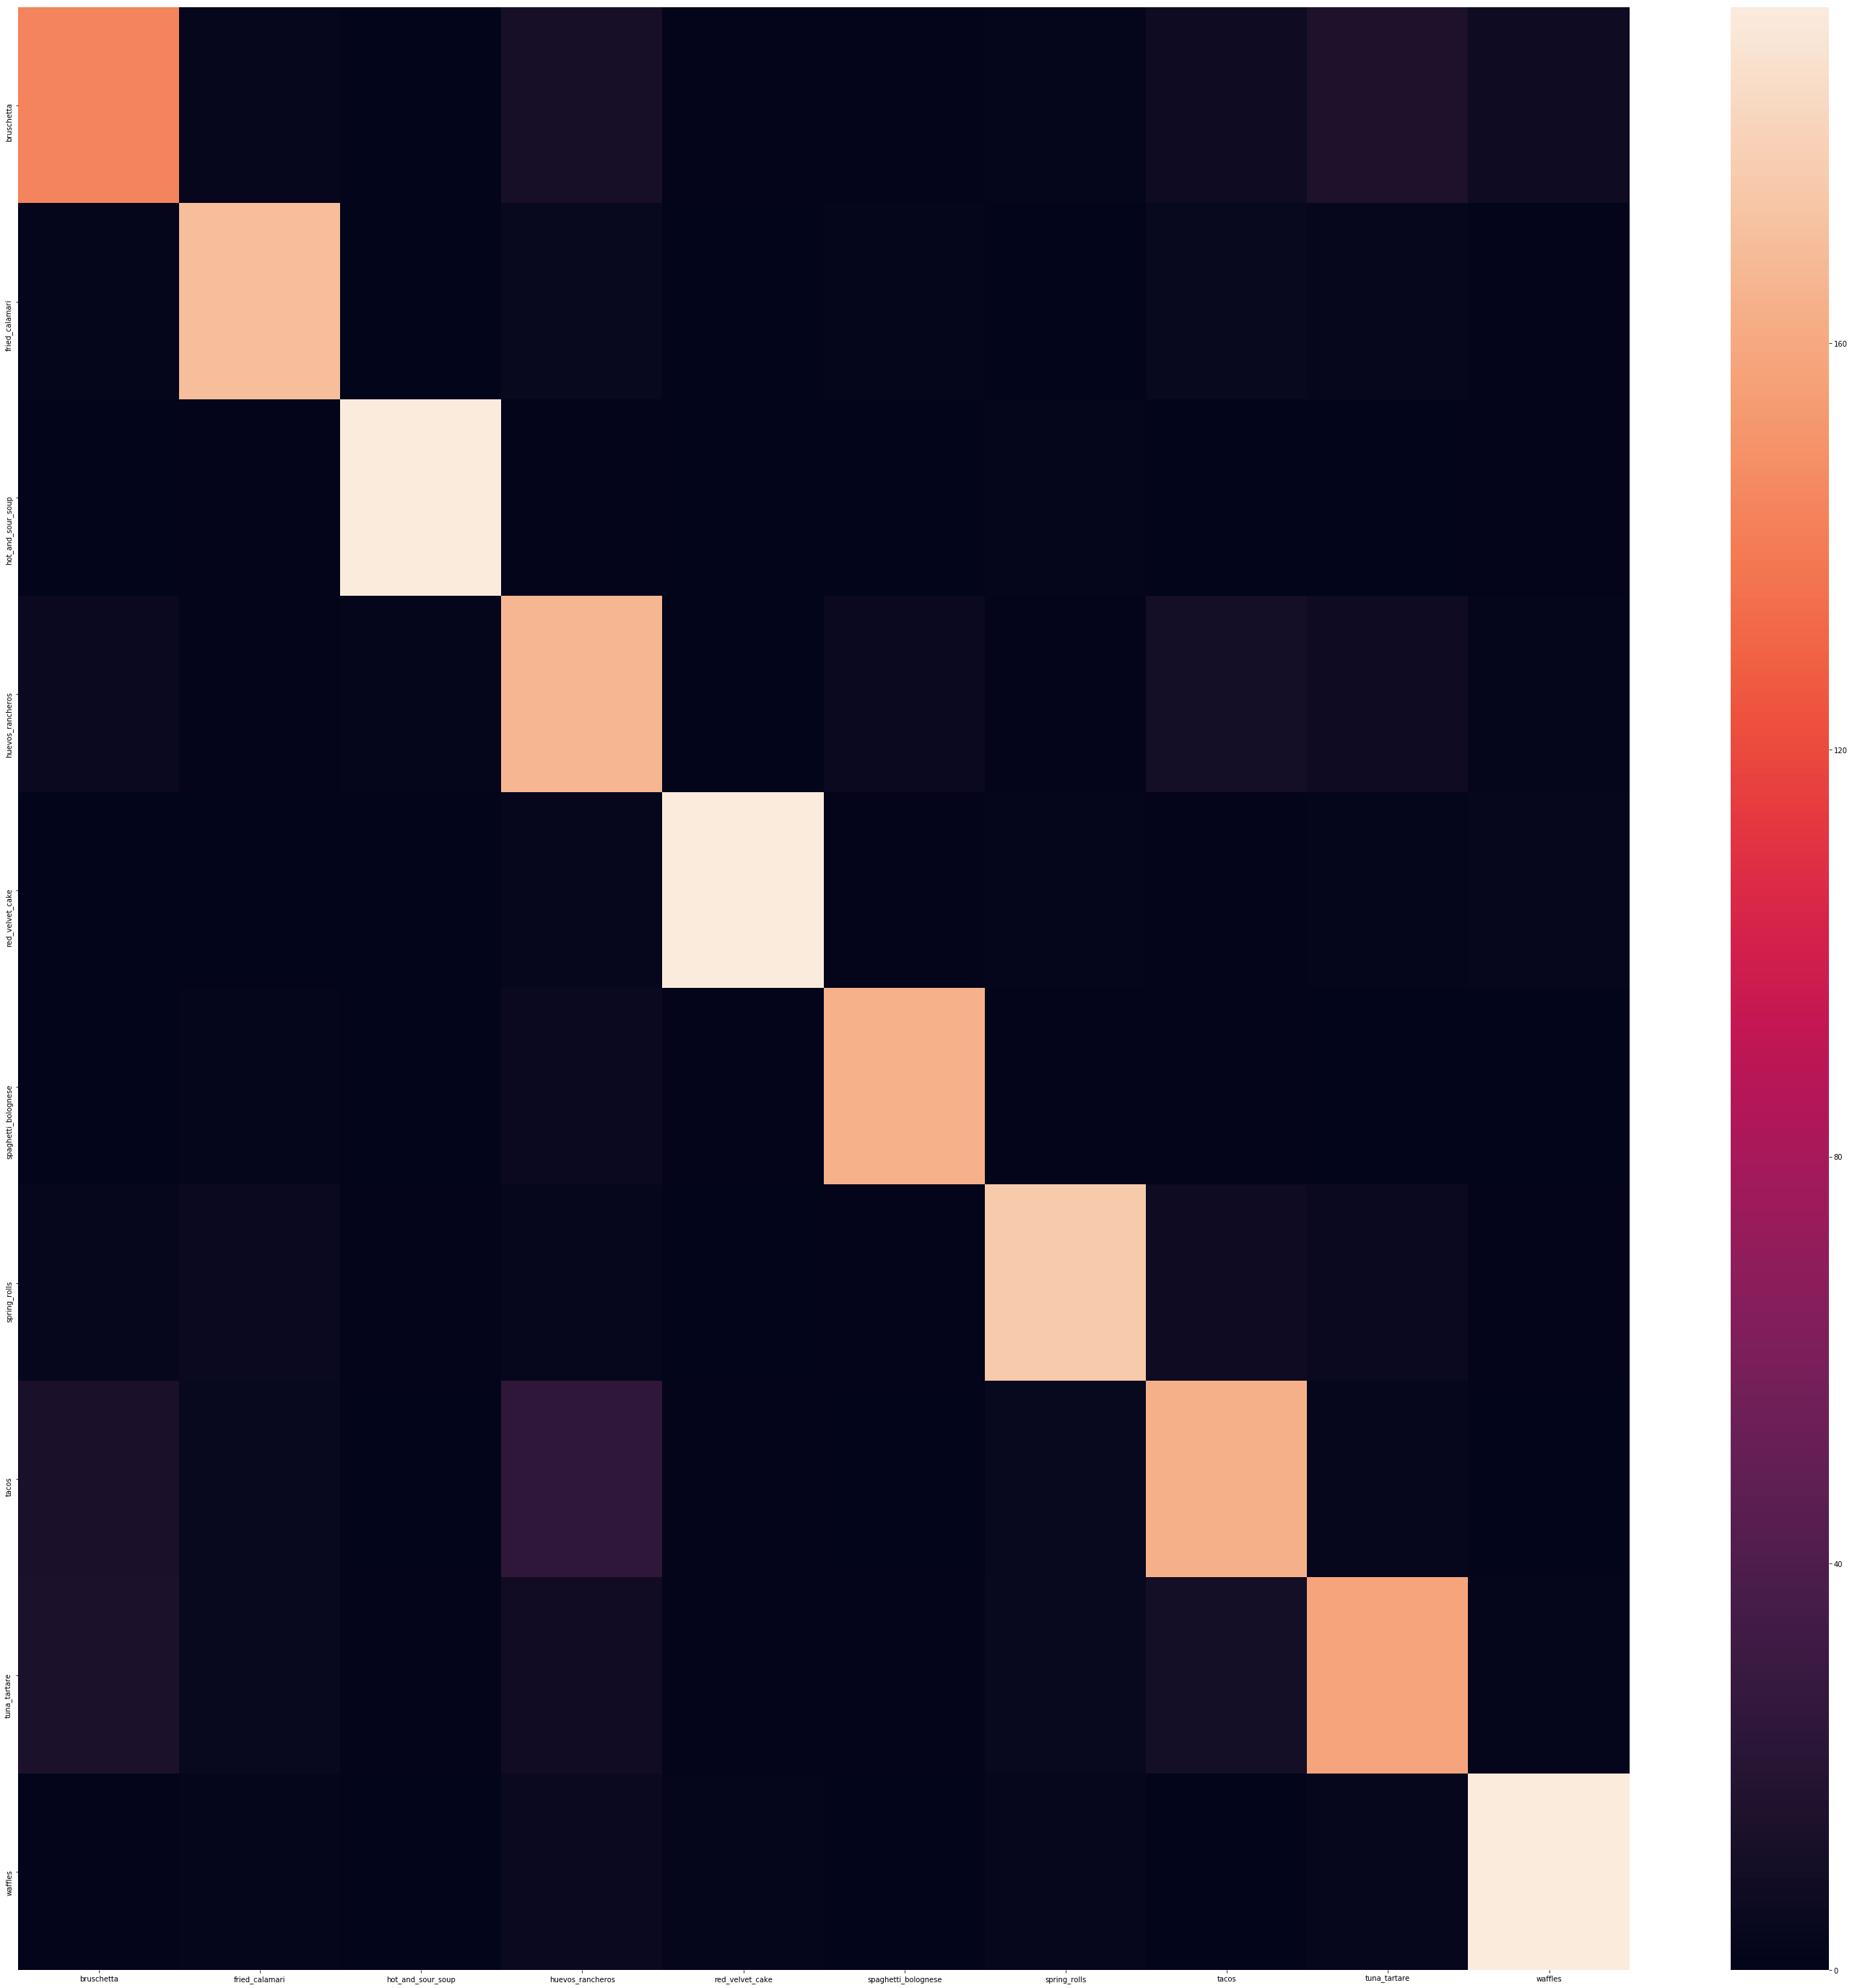

In [22]:
fig, ax = plt.subplots(figsize=(50, 50))
_ = sns.heatmap(cm, ax=ax, yticklabels=labels, xticklabels=labels, robust=True)

In [23]:
fastai.model.model_urls

{'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
 'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
 'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
 'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
 'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth'}